### COMP 473 Group Project

#### Facial Expression Recognition: 6-Class Classification

##### Importing main libraries used

In [1]:
import os
import keras.models
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random
import PIL
import pandas as pd

classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']

#### Training Metrics Graph
Automatically update loss and accuracy of training and validation set and display the graph as the model gets trained

In [2]:
from IPython.display import clear_output


class PlotTrain(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        #To plot the graph
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], label='val_' + metric)

        axs[i].legend()
        axs[i].grid()
        plt.tight_layout()
        plt.show()

In [10]:
def myClassType(myClass):
    return_class = []
    for i in myClass:
        if (i == 0):
            return_class += ['angry']
        if (i == 1):
            return_class += ['disgust']
        if (i == 2):
            return_class += ['fear']
        if (i == 3):
            return_class += ['happy']
        if (i == 4):
            return_class += ['sad']
        if (i == 5):
            return_class += ['surprise']
    return return_class

### Sample image from each class

Training_69920331.jpg
Training_95344687.jpg
Training_68270314.jpg
PublicTest_17688489.jpg
PublicTest_147590.jpg
PublicTest_34487688.jpg
Training_49791926.jpg


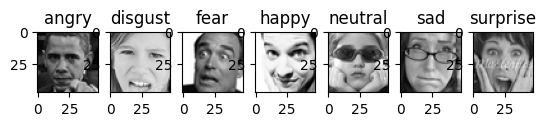

In [3]:
path_fer_2013_train = 'D:\Concordia\COMP473\\files\FER_2013_DataSet\FER_2013_Original'

for index, directory_name in enumerate(os.listdir(path_fer_2013_train)):
    joined_directory = os.path.join(path_fer_2013_train, directory_name)
    sample_image = random.choice(os.listdir(joined_directory))
    print(sample_image)
    image = PIL.Image.open(os.path.join(joined_directory, sample_image)).convert('I')
    plt.subplot(1, 7, index + 1)
    plt.title(directory_name)
    plt.imshow(image)

### Printing of datafram to show matching labels

In [4]:

#load all the data
def get_all_file_paths(path):
    all_filenames = []
    for root, subdirs, files in os.walk(path):
        for name in files:
            absolute_filepath = os.path.join(root, name)
            relative_file_path = os.path.join(os.path.basename(root), name)
            all_filenames.append(relative_file_path)
            # print(name)
    return all_filenames


def get_label(file_name):
    if 'angry' in str(file_name):
        return 0
    if 'disgust' in str(file_name):
        return 1
    if 'fear' in str(file_name):
        return 2
    if 'happy' in str(file_name):
        return 3
    if 'sad' in str(file_name):
        return 4
    if 'surprise' in str(file_name):
        return 5


categories = []

filenames = get_all_file_paths(path_fer_2013_train)
# use list() to show all the values inside a list
# print(list(filenames))
# randomize the files
random.shuffle(filenames)
for filename in filenames:
    categories.append(get_label(filename))
# print(list(categories))

# join the filename and categories list together

dataframe = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


<AxesSubplot: >

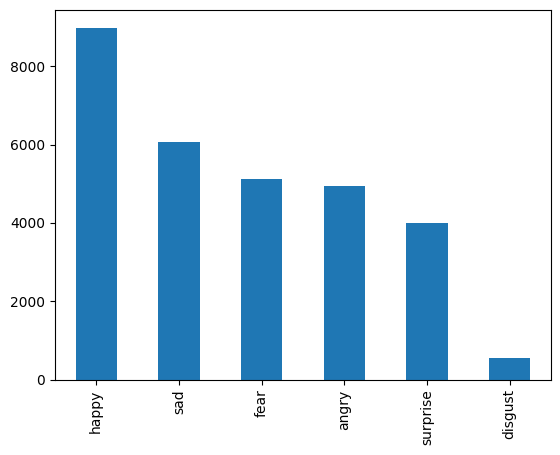

In [5]:
dataframe["category"] = dataframe["category"].replace(
    {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', })
dataframe['category'].value_counts().plot.bar()

### Training and Testing Models

Code implementation for each modes is the same throughout the experiment.
<br>Thus, only the first model contains information and comments about the implmentation.
<br>Simply need to change the variables 'path', 'MODEL_NAME' for each models
<br>
<br>To avoid overfitting, early stopping feature is implemented to stop the training (TO DO)

#### No Pre-Processing

Training and Testing on the basic model with Dataset1

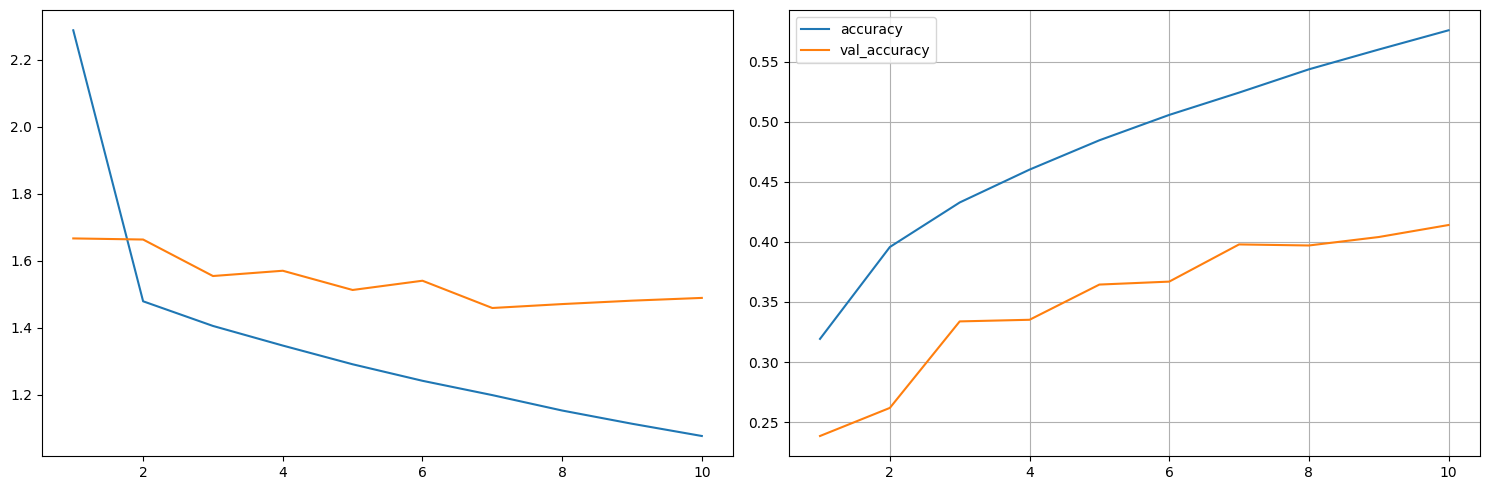

494/494 [==============================] - 155s 311ms/step - loss: 1.0764 - accuracy: 0.5762 - val_loss: 1.4886 - val_accuracy: 0.4141


In [9]:

path_train = 'D:\Concordia\COMP473\\files\FER_2013_DataSet\FER_2013_Agumented1\\train'
path_val = 'D:\Concordia\COMP473\\files\FER_2013_DataSet\FER_2013_Agumented1\\val'

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(7, activation="softmax")
])
model.build()
# prints summary of our model.
model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

# monitor	Quantity to be monitored.
# patience	Number of epochs with no improvement after which training will be stopped.
# verbose	Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
# mode	One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 77259 images belonging to 6 classes.


C:\Users\phael\AppData\Local\Temp\ipykernel_28064\794610637.py:30: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_predict = model.predict_generator(test_ds)


              precision    recall  f1-score   support

       angry       0.37      0.32      0.34     12896
     disgust       0.51      0.02      0.04      1430
        fear       0.31      0.27      0.29     13325
       happy       0.62      0.71      0.66     23387
         sad       0.39      0.42      0.40     15808
    surprise       0.56      0.60      0.58     10413

    accuracy                           0.48     77259
   macro avg       0.46      0.39      0.38     77259
weighted avg       0.47      0.48      0.47     77259



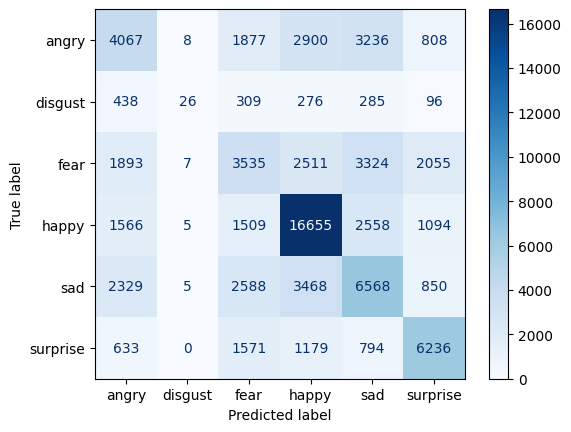

In [31]:
WEIGHT_NAME = 'ENTER MODEL WEIGHT NAME.h5'

#Fetch testing data from the dataset1
test_dir = 'ENTER TEST SET DIRECTORY'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500, class_mode='categorical', color_mode="grayscale", shuffle = False)

model.load_weights("1_basic_d1.h5")

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)
 
print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset2

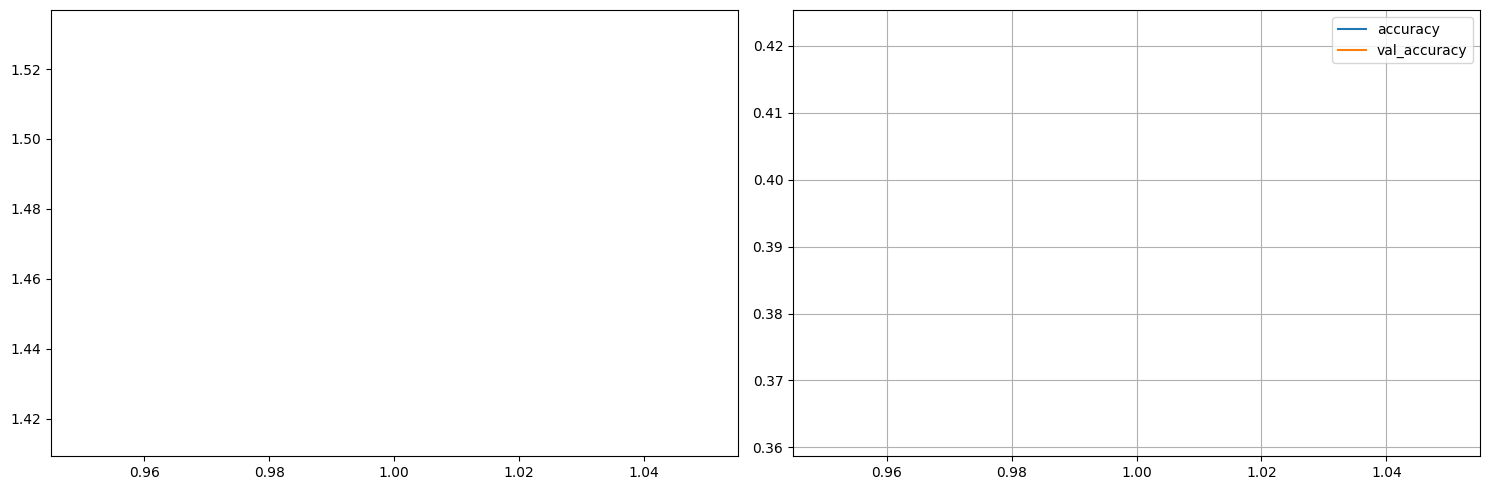

494/494 [==============================] - 1193s 2s/step - loss: 1.5311 - accuracy: 0.3617 - val_loss: 1.4151 - val_accuracy: 0.4223
Epoch 2/15
445/494 [==========================>...] - ETA: 2:00 - loss: 1.3686 - accuracy: 0.4469

KeyboardInterrupt: 

In [33]:
path_train = 'D:\Concordia\COMP473\\files\FER_2013_DataSet\FER_2013_Agumented2\\train'
path_val = 'D:\Concordia\COMP473\\files\FER_2013_DataSet\FER_2013_Agumented2\\val'

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Training and Testing on the basic model with Dataset3

In [ ]:
path_train = 'ENTER YOUR PATH FOR TRAINING SET'
path_val = 'ENTER YOUR PATH FOR VALIDATION SET'

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "MODEL NAME.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)